In [1]:
#load up the basics
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

#Set GPU to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#import TF stuff
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

TF version: 2.9.1
 GPU: /device:GPU:0


In [2]:
#Load up the TF model

#model path
model_path = '../model/NOAA_NewLoss_fullmodel_model'

# load model into tf
model = tf.keras.models.load_model(model_path, compile = True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768, 1024,   0           []                               
                                3)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 768, 1024, 4  52          ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 768, 1024, 4  16         ['conv2d[0][0]']                 
 alization)                     )                                                             

                                )                                                                 
                                                                                                  
 activation_7 (Activation)      (None, 192, 256, 16  0           ['batch_normalization_7[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_7 (Conv2D)              (None, 192, 256, 16  20752       ['activation_6[0][0]']           
                                )                                                                 
                                                                                                  
 add_2 (Add)                    (None, 192, 256, 16  0           ['activation_7[0][0]',           
                                )                                 'conv2d_7[0][0]']               
          

 activation_15 (Activation)     (None, 48, 64, 64)   0           ['batch_normalization_15[0][0]'] 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 48, 64, 64)   331840      ['activation_15[0][0]']          
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 96, 128, 64)  0           ['conv2d_16[0][0]']              
                                                                                                  
 concatenate (Concatenate)      (None, 96, 128, 96)  0           ['up_sampling2d[0][0]',          
                                                                  'add_3[0][0]']                  
                                                                                                  
 batch_normalization_16 (BatchN  (None, 96, 128, 96)  384        ['concatenate[0][0]']            
 ormalizat

                                                                                                  
 conv2d_25 (Conv2D)             (None, 384, 512, 16  656         ['concatenate_2[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_23 (BatchN  (None, 384, 512, 16  64         ['conv2d_23[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 batch_normalization_24 (BatchN  (None, 384, 512, 16  64         ['conv2d_25[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activatio

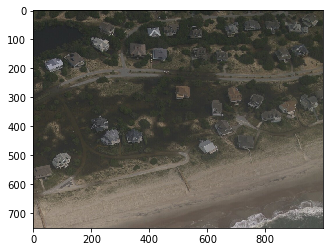

In [3]:
#find an image
ImPath = "../data/P26055100-1_EBG.jpg"
img = matplotlib.image.imread(ImPath)
imgplot = plt.imshow(img)

In [4]:
# standardization using adjusted standard deviation, as required by Gym model

def standardize(img):

    N = np.shape(img)[0] * np.shape(img)[1]
    s = np.maximum(np.std(img), 1.0 / np.sqrt(N))
    m = np.mean(img)
    img = (img - m) / s
    del m, s, N
    #
    if np.ndim(img) == 2:
        img = np.dstack((img, img, img))

    return img

In [5]:
## And we can send it through the model

TestIm = tf.keras.preprocessing.image.load_img(ImPath,target_size = (768,1024))
TestIm = tf.keras.preprocessing.image.img_to_array(TestIm)
TestIm = standardize(TestIm)
TestIm = np.expand_dims(TestIm,axis=0)
print(TestIm.shape)
TestPred = model.predict(TestIm)
TestPred.shape

(1, 768, 1024, 3)
1/1 [==============================] - 3s 3s/step


(1, 768, 1024, 4)

In [6]:
#these are the actual indicies, thes classes (whcih we get with argmax)

am_input = TestPred.squeeze()
lab = np.argmax(am_input,-1)

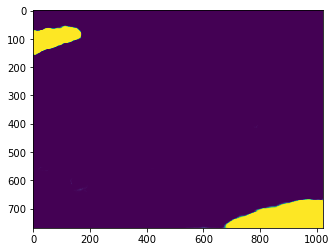

In [7]:
#lets look at the softmax
#This should be water
plt.imshow(am_input[:,:,0])

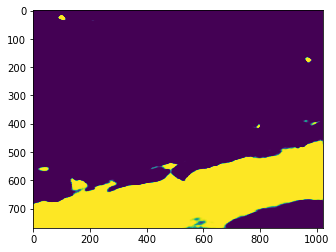

In [8]:
#lets look at the softmax
#This should be sand
plt.imshow(am_input[:,:,1])

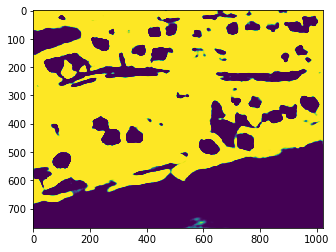

In [9]:
#lets look at the softmax
#This should be veg
plt.imshow(am_input[:,:,2])

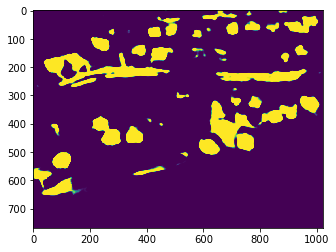

In [10]:
#lets look at the softmax
#This should be development
plt.imshow(am_input[:,:,3])

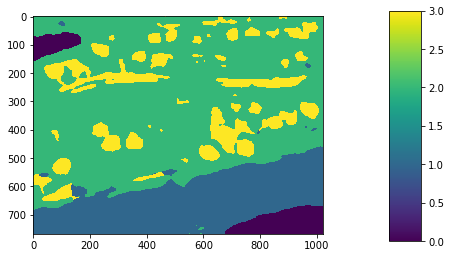

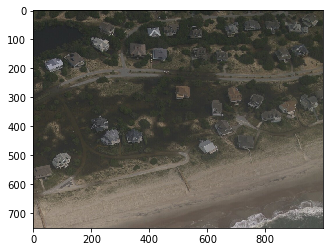

In [11]:
#look at the argmaxed labels vs the image
# water (0), sand (1), vegetation (3), dev(4)

plt.imshow(lab)
cax = plt.axes([1, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()
plt.imshow(img)

In [12]:
#here i am loading in the custom loss and metrics

#define new Dice coeff
def E_dice_coef(y_true, y_pred):
    smooth = 10e-6
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return dice

#define new multi-dice workflow
def E_dice_multi_metric(nclasses):
    
    def dice_coef(y_true, y_pred):
        dice = 0
        #can't have an argmax in a loss
        #y_pred = tf.one_hot(tf.argmax(y_pred, -1), 4)
        for index in range(nclasses):
            dice += E_dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
        return dice/nclasses
    
    return dice_coef

#define the loss, which calls the metrics
def E_dice_coef_loss(nclasses):
    
    def E_dice_MC_coef_loss(y_true, y_pred):
        dice = 0
        #can't have an argmax in a loss
        #y_pred = tf.one_hot(tf.argmax(y_pred, -1), 4)
        for index in range(nclasses):
            dice += E_dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
        return 1 - (dice/nclasses)
    
    return E_dice_MC_coef_loss



def new_iou(y_true, y_pred):
    smooth = 10e-6
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union =  tf.reduce_sum(y_true_f + y_pred_f) - intersection
    return (intersection+smooth)/(union+smooth)

def E_iou(nclasses):
    
    def mean_iou(y_true, y_pred):
        iousum = 0
        y_pred = tf.one_hot(tf.argmax(y_pred, -1), 4)
        for index in range(nclasses):
            iousum += new_iou(y_true[:,:,:,index], y_pred[:,:,:,index])
        return iousum/nclasses
    
    return mean_iou


def iou1(y_true, y_pred):
    y_pred = tf.one_hot(tf.argmax(y_pred, -1), 4)
    return new_iou(y_true[:,:,:,0], y_pred[:,:,:,0])

def iou2(y_true, y_pred):
    y_pred = tf.one_hot(tf.argmax(y_pred, -1), 4)
    return new_iou(y_true[:,:,:,1], y_pred[:,:,:,1])

def iou3(y_true, y_pred):
    y_pred = tf.one_hot(tf.argmax(y_pred, -1), 4)
    return new_iou(y_true[:,:,:,2], y_pred[:,:,:,2])

def iou4(y_true, y_pred):
    y_pred = tf.one_hot(tf.argmax(y_pred, -1), 4)
    return new_iou(y_true[:,:,:,3], y_pred[:,:,:,3])

In [13]:
num_classes = 4

#compile the model
model.compile(optimizer = 'adam', 
              loss =E_dice_coef_loss(num_classes), 
              metrics = [E_dice_multi_metric(num_classes), 
                         E_iou(num_classes), 
                         tf.keras.metrics.OneHotMeanIoU(num_classes=num_classes),
                         iou1,
                         tf.keras.metrics.OneHotIoU(num_classes=num_classes, target_class_ids=[0]),
                         iou2,
                         tf.keras.metrics.OneHotIoU(num_classes=num_classes, target_class_ids=[1]),
                         iou3,
                         tf.keras.metrics.OneHotIoU(num_classes=num_classes, target_class_ids=[2]),
                         iou4,
                         tf.keras.metrics.OneHotIoU(num_classes=num_classes, target_class_ids=[3])
                        ]
             )

In [15]:
#run model.evalaute()

#this is a fn to make sure the doodler-derived labels go from 0- (num_classes-1)

def D_Filter(image):
    image[image>(num_classes-1)] = (num_classes-1)
    return image


# #can turn on this function to 'roll' the labels to the correct poisiton
# def D_Filter(image):
#     image = image-1
#     image[image == (-1)] = (3) #class -1 -> 4
#     image[image>(num_classes-1)] = (num_classes-1)
#     return image

TestLabP = "../data/P26055100-1_EBG_label.jpg"
TestLab = tf.keras.preprocessing.image.load_img(TestLabP,target_size = (768,1024),color_mode = "grayscale")
TestLab = tf.keras.preprocessing.image.img_to_array(TestLab)
TestLab = D_Filter(TestLab)
TestLab = tf.keras.utils.to_categorical(TestLab, num_classes=4)
TestLab = np.expand_dims(TestLab,axis=0)

results = model.evaluate(TestIm,TestLab)

1/1 [==============================] - 2s 2s/step - loss: 0.3052 - dice_coef: 0.6948 - mean_iou: 0.5527 - one_hot_mean_io_u: 0.5527 - iou1: 0.3280 - one_hot_io_u: 0.3280 - iou2: 0.8065 - one_hot_io_u_1: 0.8065 - iou3: 0.6120 - one_hot_io_u_2: 0.6120 - iou4: 0.4642 - one_hot_io_u_3: 0.4642


In [16]:
results

[0.30522000789642334,
 0.6947799921035767,
 0.5526818633079529,
 0.5526819229125977,
 0.32802194356918335,
 0.32802194356918335,
 0.8064969182014465,
 0.8064969182014465,
 0.6120409965515137,
 0.6120409965515137,
 0.4641677439212799,
 0.4641677439212799]